In [4]:
import numpy as np
lattice_name = 'p3x_v24_mco'
dCx = np.load('dCx_p3_on.npy') # Jacobian calculated using HCM / VCM
dCy = np.load('dCy_p3_on.npy')
correctors_kick = 1.e-4
dk = 1.e-4 # change in quads strengths for

Load the lattice - radiation off


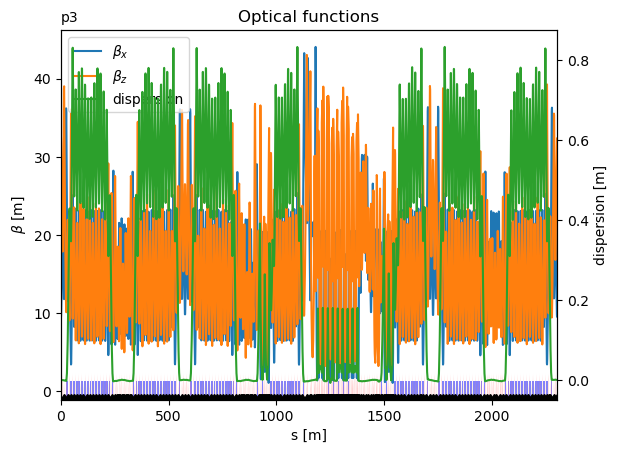

The lattice p3x_v24_mco has 246 BPMs, 607 Correctors, 355 Dipoles, and 415 quadrupoles. Number of used correctors = 96
The ideal lattice tune values: [37.12356293 30.2746517 ], The chromaticity values: [3.849223   3.77608463]. 
 BPM_to_corrector_response_matrices (Model) ..
 Generate quadrupoles response (Jacobian) ..


In [5]:
print(f"Load the lattice - radiation off")
from at_modules_loco import *
ring = at.load_mat(lattice_name)
ring.radiation_off()
ring.plot_beta()

# elements indices
quads_indices = get_refpts(ring,at.elements.Quadrupole)
bpm_indices = get_refpts(ring, at.elements.Monitor)
corrector_indices= get_refpts(ring , at.elements.Corrector)
dipole_indices = get_refpts(ring, elements.Dipole)
sext_indexes = get_refpts(ring,at.elements.Sextupole)

ORM_230426_3 =  np.loadtxt("ORM_230426_3.txt")   # measured ORM
Noise_BPMx_230426_3 =  np.loadtxt("Noise_BPMx_230426_3.txt")
Noise_BPMy_230426_3 =  np.loadtxt("Noise_BPMy_230426_3.txt")

BPM_names = load_names("BPM_names.txt")
HCM_names = load_names("HCM_names.txt")
VCM_names = load_names("VCM_names.txt")

wiggler_matrix = np.array([[1.000449786249, 4.000639844715, 0, 0,0,0], # Insert wigglers
                   [0.00022577719708, 1.00045326313, 0, 0,0,0],
                   [0, 0, 0.9786569514876, 3.970145599493,0,0],
                   [0, 0, -0.01063922161568, 0.97864807445,0,0], [0,0,0,0,0,0],[0,0,0,0,0,0]])
wiggler_indexes = get_refpts(ring,"wiggler*")
for i in wiggler_indexes:
    ring[i] = elements.M66(family_name = "wiggler", Length = 4, m66=wiggler_matrix, kwargs = "Matrix66Pass")

[elemdata0, beamdata, elemdata] = at.get_optics(ring, bpm_indices)
twiss = elemdata
print('The lattice {} has {} BPMs, {} Correctors, {} Dipoles, and {} quadrupoles. Number of used correctors = {}'.format(lattice_name, len(bpm_indices), len(corrector_indices), len(dipole_indices), len(quads_indices), len(HCM_names)+len(VCM_names)))
nominal_tune = get_tune(ring, get_integer=True)
print(f"The ideal lattice tune values: {nominal_tune}, "
      f"The chromaticity values: {get_chrom(ring)}. ")

print(" BPM_to_corrector_response_matrices (Model) ..")
Cx0, Cxy0= ORM_x(correctors_kick, ring,HCM_names)
Cy0, Cyx0= ORM_y(correctors_kick, ring, VCM_names)

print(" Generate quadrupoles response (Jacobian) ..") #NOTE: files pre-loaded, the execution of this function is time-consuming

#dCx, dCy, dCxy, dCyx = generatingQuadsResponse_(ring,Cx0, Cxy0, Cy0, Cyx0 ,correctors_kick,HCM_names,VCM_names, quads_indices, dk)


(41, 246)
(41, 246)
(55, 246)
(55, 246)


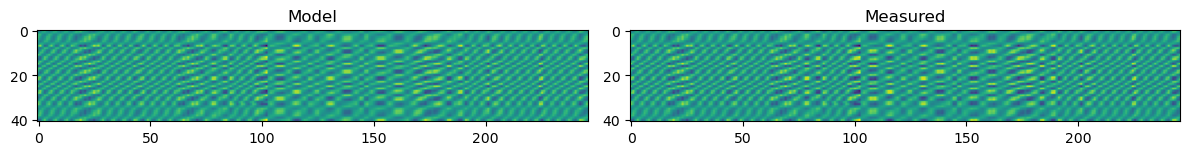

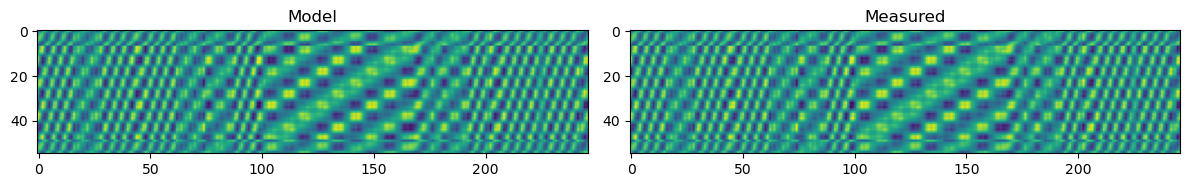

In [6]:
# measured ORMS

Cx = transpose(np.array(ORM_230426_3)[:492//2, :41])
Cy = transpose(np.array(ORM_230426_3)[492//2:, 41:])

print(shape(Cx))
print(shape(Cx0))
print(shape(Cy))
print(shape(Cy0))

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(Cx0)
plt.title('Model')
plt.subplot(1, 2, 2)
plt.imshow(Cx * 10)
plt.title('Measured')
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(Cy0)
plt.title('Model')
plt.subplot(1, 2, 2)
plt.imshow(Cy * 10)
plt.title('Measured')
plt.tight_layout()
plt.show()

In [8]:
bpm_noise = Noise_BPMy_230426_3/1000
min_value = np.min(abs(bpm_noise))
bpm_noise /= min_value
diagonal_values = 1 / np.square(bpm_noise)
W = np.diag(diagonal_values)
print(W)

[[0.01375493 0.         0.         ... 0.         0.         0.        ]
 [0.         0.01702428 0.         ... 0.         0.         0.        ]
 [0.         0.         0.14752892 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00913154 0.         0.        ]
 [0.         0.         0.         ... 0.         0.04755315 0.        ]
 [0.         0.         0.         ... 0.         0.         0.07750297]]


LOCO
LOCO iterations
NK: 415
Nm: 415
Execution time: 81.14634108543396 sec


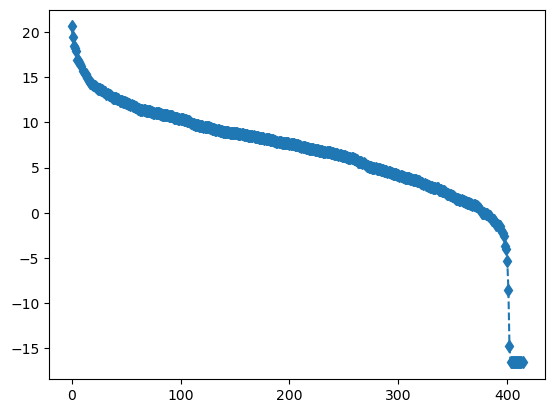

In [9]:
print('LOCO')
print('LOCO iterations')
t0 = time.time()
A, B = defineJacobianMatrices_weighted(W, Cx0, Cy0, Cx*10, Cy*10, dCx, dCy)
t1 = time.time()
print(f"Execution time: {t1-t0} sec")
Nk = len(dCx)
u, s, v = np.linalg.svd(A, full_matrices=True)
smat = 0.0 * A
si = s ** -1
plt.plot(np.log(s), 'd--')

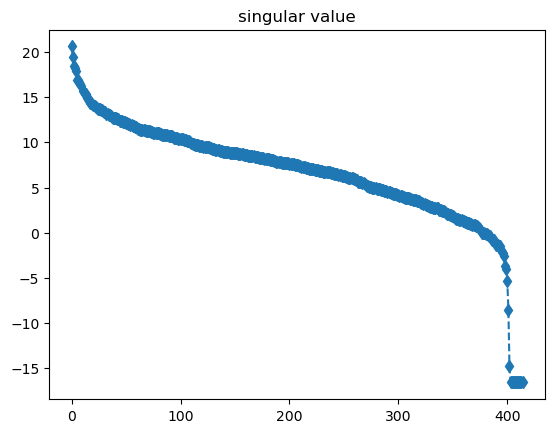

number of singular values 415


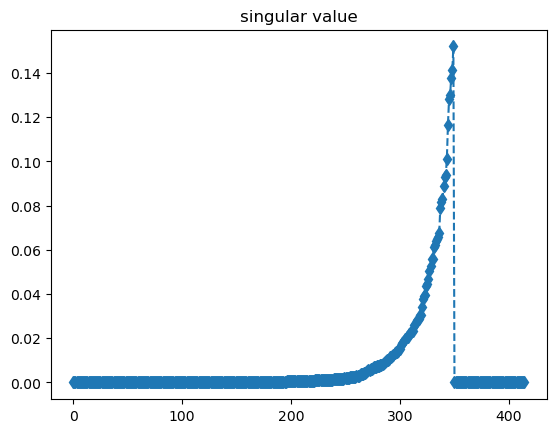

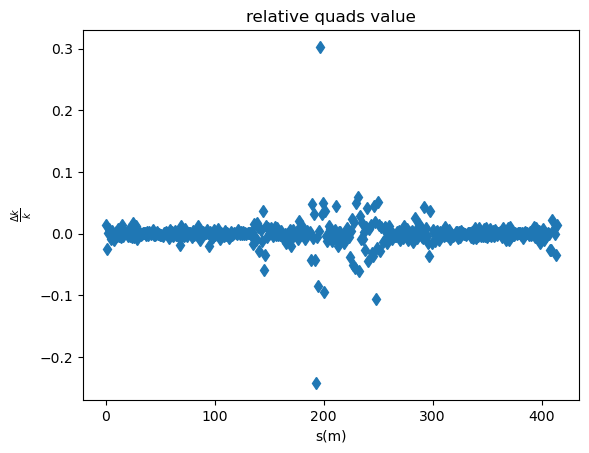

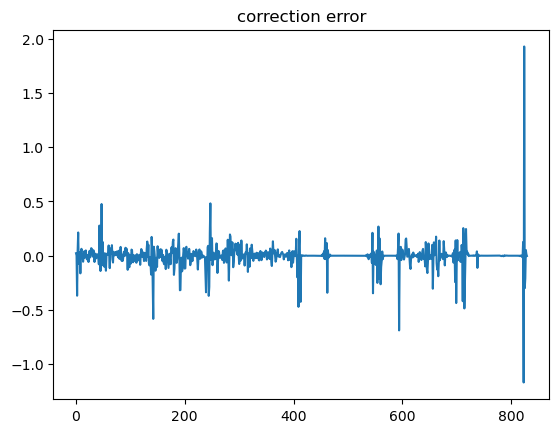

[ 1.32757934e-02 -2.49671705e-02  2.76034771e-04  8.01148359e-03
  1.42754988e-03 -9.15774875e-03  4.82584958e-03 -9.56606224e-03
 -2.19485059e-03  3.40042145e-03 -4.07911504e-03  7.00347470e-03
 -4.08852464e-03 -3.59226578e-03 -4.81931870e-03  1.36908424e-02
 -3.83503185e-03  5.04962318e-03  2.72187745e-04  2.19872653e-03
 -3.91027778e-03  6.81941150e-03 -3.99314241e-03 -2.57182531e-03
 -5.70189923e-03  1.76407242e-02 -5.00833876e-03  7.75791822e-03
  1.16102175e-02 -7.95597143e-03 -2.46824861e-03  1.76287338e-03
 -1.43633225e-03 -7.94350959e-04  1.27283239e-03  2.06142181e-04
  1.12405764e-03 -1.59347007e-03  2.74233303e-03 -2.61153671e-03
  3.44775141e-03 -1.19507397e-03  9.92511374e-04  6.32650992e-03
 -1.44915569e-03 -2.89624975e-03 -7.38651477e-04  2.61323386e-03
  4.32661315e-05 -4.67601613e-04 -2.49171542e-03 -2.41355945e-03
 -4.60818294e-03  1.14506269e-03  6.89914886e-04  2.29816871e-03
  1.23684986e-03  1.62449017e-03 -7.02834378e-03  5.44238361e-03
 -2.68724696e-03  3.36815

In [11]:
sCut = 350
r = getInverse(A, B, Nk, sCut, showPlots = 'True')
np.savetxt('relative quads values', r)
print(r)